In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Custom mGRU Cell

In [4]:
class mGRUCell(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        self.output_size = units
        super(mGRUCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W_z = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', name='W_z')
        self.b_z = self.add_weight(shape=(self.units,), initializer='zeros', name='b_z')
        self.W_h = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', name='W_h')
        self.b_h = self.add_weight(shape=(self.units,), initializer='zeros', name='b_h')
        self.built = True

    def call(self, inputs, states):
        h_prev = states[0]
        z = tf.sigmoid(tf.matmul(inputs, self.W_z) + self.b_z)
        h_tilde = tf.tanh(tf.matmul(inputs, self.W_h) + self.b_h)
        h = (1 - z) * h_prev + z * h_tilde
        return h, [h]

### Load and preprocess dataset

In [5]:
def load_and_preprocess_data(dataset_path):
    df = pd.read_csv(dataset_path)
    df = df.dropna()
    X = df.iloc[:, :-2].values
    y = df.iloc[:, -2].values
    le = LabelEncoder()
    y_multi = le.fit_transform(y)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y_multi, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test, le.classes_

### Build mGRU model for multi-class classification

In [11]:
def build_mgru_model(num_features, num_classes):
    model = keras.Sequential([
        keras.layers.RNN(mGRUCell(128), return_sequences=True, input_shape=(1, num_features)),
        keras.layers.RNN(mGRUCell(64), return_sequences=True),
        keras.layers.RNN(mGRUCell(32), return_sequences=False),
        keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Main execution

In [7]:
dataset_path = '/content/drive/MyDrive/multi-vector-IDS/code/CICIoMT2024/CICIoMT2024_selected_features_dataset.csv'

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test, classes = load_and_preprocess_data(dataset_path)

In [9]:
X_train_reshaped = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val_reshaped = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

### Train mGRU model

In [12]:
model = build_mgru_model(X_train.shape[1], len(classes))
start_time = time.time()
history = model.fit(X_train_reshaped, y_train, epochs=40, batch_size=1000, validation_data=(X_val_reshaped, y_val))
training_time = time.time() - start_time

Epoch 1/40
612/612 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8020 - loss: 0.6889 - val_accuracy: 0.9930 - val_loss: 0.0335
Epoch 2/40
612/612 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9943 - loss: 0.0260 - val_accuracy: 0.9957 - val_loss: 0.0164
Epoch 3/40
612/612 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9961 - loss: 0.0152 - val_accuracy: 0.9967 - val_loss: 0.0115
Epoch 4/40
612/612 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - accuracy: 0.9970 - loss: 0.0110 - val_accuracy: 0.9973 - val_loss: 0.0092
Epoch 5/40
612/612 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.9974 - loss: 0.0090 - val_accuracy: 0.9976 - val_loss: 0.0079
Epoch 6/40
612/612 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9975 - loss: 0.0084 - val_accuracy: 0.9976 - val_loss: 0.0072
Epoch 7/40
612/612 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9977 - loss: 0.0073 - val_accuracy: 0.9978 - val_loss: 0.0080
Epoch 8/40
612/612 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9978 - loss: 0.0066 - val_ac

### Evaluate

In [13]:
start_time = time.time()
y_pred = model.predict(X_test_reshaped)
detection_time = (time.time() - start_time) / len(y_test)
y_pred_class = np.argmax(y_pred, axis=1)

2458/2458 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


### Metrics

In [14]:
cm = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:\n", cm)
print(classification_report(y_test, y_pred_class))

accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class, average='weighted')
recall = recall_score(y_test, y_pred_class, average='weighted')
f1 = f1_score(y_test, y_pred_class, average='weighted')
mcc = matthews_corrcoef(y_test, y_pred_class)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"MCC: {mcc:.4f}")

for i in range(len(classes)):
    tp = cm[i, i]
    fn = np.sum(cm[i, :]) - tp
    fp = np.sum(cm[:, i]) - tp
    tn = np.sum(cm) - (fp + fn + tp)

    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    far = fp / (fp + tn) if (fp + tn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

    print(f"\nClass {classes[i]}:")
    print(f"  Sensitivity : {sensitivity:.4f}")
    print(f"  Specificity: {specificity:.4f}")
    print(f"  FAR: {far:.4f}")
    print(f"  FPR: {fpr:.4f}")


model.save('mce_model.h5')
model_size = os.path.getsize('mce_model.h5') / 1024  # KB
print(f"\nModel size: {model_size:.2f} KB")
print(f"Training time: {training_time:.2f} seconds")

Confusion Matrix:
 [[11181     0     0     6     0     0     0]
 [    0 11364     0     0     1     1     2]
 [    0     0 11319     0     3     0     0]
 [   23     0     0 11102     0     0     0]
 [    0     4    11     1 11238     1     3]
 [    0     0     0     0     3 11142     1]
 [    0     0     0     0     1     1 11235]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11187
           1       1.00      1.00      1.00     11368
           2       1.00      1.00      1.00     11322
           3       1.00      1.00      1.00     11125
           4       1.00      1.00      1.00     11258
           5       1.00      1.00      1.00     11146
           6       1.00      1.00      1.00     11237

    accuracy                           1.00     78643
   macro avg       1.00      1.00      1.00     78643
weighted avg       1.00      1.00      1.00     78643

Accuracy: 0.9992
Precision: 0.9992
Recall: 0.9992
F1-Score: 0.9992
M

### Visualization

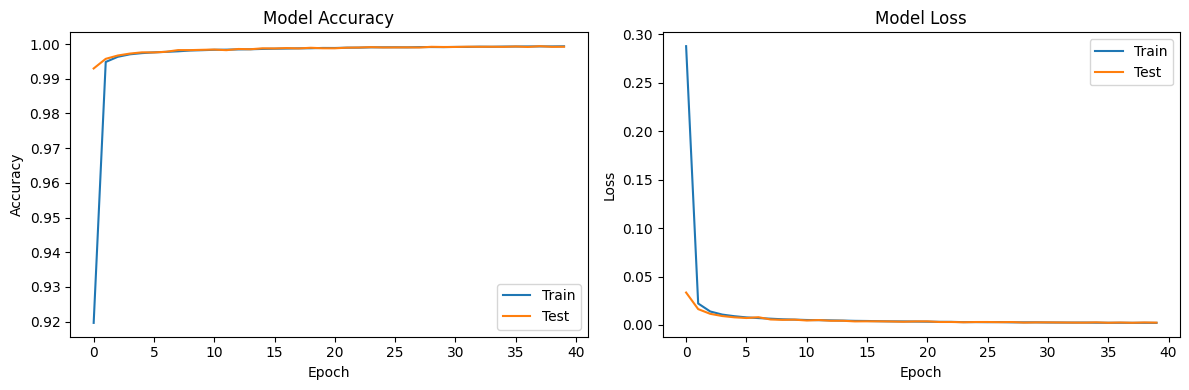

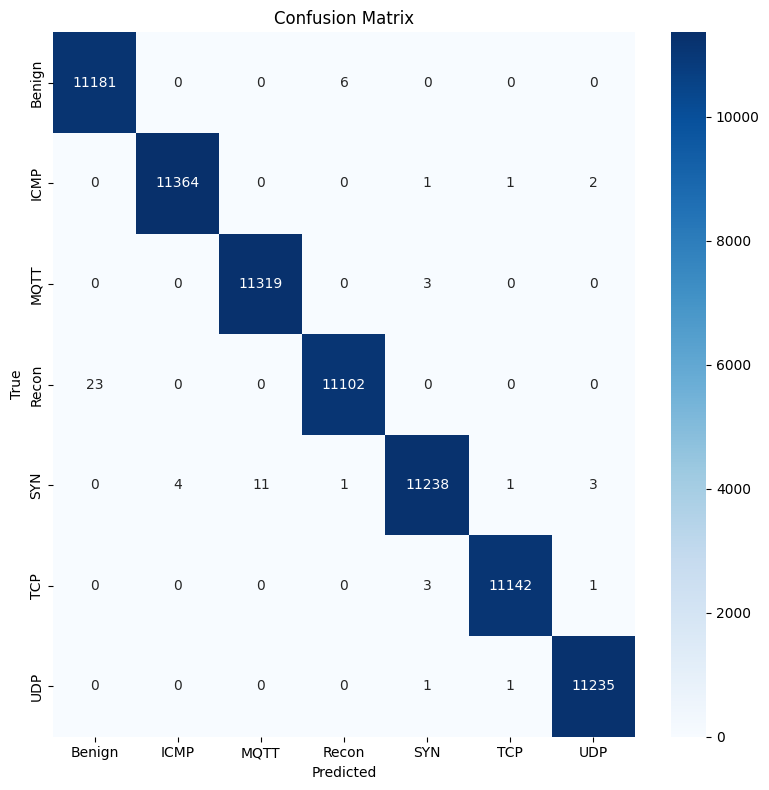

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

print("\n")

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()